In [1]:
from collections import defaultdict
import io

import torch
from torch.utils.data import DataLoader

from compressai import zoo

import torchmetrics as tm
import torchmetrics.functional as tmF

import neuralcompression as nc
import neuralcompression.functional as ncF
import neuralcompression.metrics as ncm

import torchvision.transforms as tfms
import numpy as np

from tqdm import tqdm

import math
from PIL import Image

import matplotlib.pyplot as plt

Using /home/babakov/.cache/torch_extensions/py38_cu102 as PyTorch extensions root...
Emitting ninja build file /home/babakov/.cache/torch_extensions/py38_cu102/_pmf_to_quantized_cdf/build.ninja...
Building extension module _pmf_to_quantized_cdf...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module _pmf_to_quantized_cdf...


# Data

In [2]:
from NeuralCompression.neuralcompression.data._kodak import Kodak

In [3]:
ds = Kodak("kodak", transform = tfms.ToTensor())
dl = DataLoader(ds, batch_size = 1)

In [4]:
for i, img in enumerate(dl): 
    print(img.shape)
    break

torch.Size([1, 3, 512, 768])


# CP

In [5]:
image_to_show = ds[0]
# sample_image = np.reshape(image_to_show, (image_to_show.shape[1], image_to_show.shape[2], image_to_show.shape[0]))

sample_image = np.transpose(image_to_show,(1,2,0))

sample_image.shape

torch.Size([512, 768, 3])

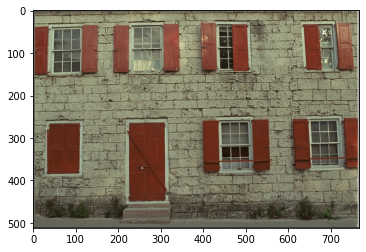

In [6]:
plt.imshow(sample_image);

In [7]:
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil

In [8]:
random_state = 12345

# image = face()
# image = tl.tensor(zoom(face(), (0.3, 0.3, 1)), dtype='float64')
# image = tl.tensor(zoom(face(), (0.8, 0.8, 1)), dtype='float64')

image = torch.tensor(sample_image)
# image = tl.tensor(zoom(face(), (0.3, 0.3, 1)), dtype='float64')
image = tl.tensor(image, dtype='float64')

<ipython-input-8-4c5d4b2687cd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(sample_image)


In [9]:
def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

In [17]:
image.shape

(512, 768, 3)

In [15]:
cp_rank = 2

# Perform the CP decomposition
weights, factors = parafac(image, rank=cp_rank, init='random', tol=10e-6)
# Reconstruct the image from the factors
cp_reconstruction = tl.cp_to_tensor((weights, factors))

In [16]:
sum([np.prod(param.shape) for param in [weights] + factors]) * 32 / image.shape[0] / image.shape[1]

0.208984375

In [20]:
cp_rank = 20
# Perform the CP decomposition
weights, factors = parafac(image, rank=cp_rank, init='random', tol=10e-6)
# Reconstruct the image from the factors
cp_reconstruction = tl.cp_to_tensor((weights, factors))

In [21]:
sum([np.prod(param.shape) for param in [weights] + factors]) * 32 / image.shape[0] / image.shape[1]

2.08984375

In [19]:
sum([np.prod(param.shape) for param in [weights] + factors]) * 32 / image.shape[0] / image.shape[1]

2.6123046875

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
ax.set_axis_off()
ax.imshow(to_image(image))
ax.set_title('original')

ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
ax.imshow(to_image(cp_reconstruction))
ax.set_title('CP')

plt.tight_layout()
plt.show()

In [96]:
metrics = tm.MetricCollection(
    tm.PSNR(), 
    tm.MeanSquaredError(), 
    ncm.MultiscaleStructuralSimilarity()#
)

/home/babakov/.local/lib/python3.8/site-packages/deprecate/deprecation.py:115: FutureWarning: The `PSNR` was deprecated since v0.7 in favor of `torchmetrics.image.psnr.PeakSignalNoiseRatio`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


In [ ]:
image_shape = (1,3,256,256)

image_a = torch.randn(image_shape)
image_b = torch.randn(image_shape)

metrics(image_a, image_b)

In [ ]:
image_t = torch.tensor(np.expand_dims( np.transpose(image,(2,0,1)),0))
cp_reconstruction_t = torch.tensor(np.expand_dims( np.transpose(cp_reconstruction,(2,0,1)),0))

In [ ]:
metrics(image_t, cp_reconstruction_t)

# Tucker

In [91]:
image_shape = (1, 3, 512, 768)

image = torch.randn(image_shape)
image = tl.tensor(image, dtype='float32')

In [93]:
# Tucker decomposition
tucker_rank = [18] * 4
core, tucker_factors = tucker(image, rank=tucker_rank, init='random', tol=10e-5, random_state=random_state)
sum([np.prod(param.shape) for param in [core] + tucker_factors]) * 32 / image.shape[-2] / image.shape[-1]

1.9549153645833333

In [97]:
reconstruction = tl.tucker_to_tensor((core, tucker_factors))

In [101]:
image = torch.tensor(image).double()
reconstruction = torch.tensor(reconstruction).double()

<ipython-input-101-766139f60292>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).double()
<ipython-input-101-766139f60292>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstruction = torch.tensor(reconstruction).double()


In [102]:
metrics(image, reconstruction)

{'PSNR': tensor(7.9130, dtype=torch.float64),
 'MeanSquaredError': tensor(0.9619),
 'MultiscaleStructuralSimilarity': tensor(0.0987)}

In [ ]:
tucker_factors[0].shape, tucker_factors[1].shape

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
ax.set_axis_off()
ax.imshow(to_image(image))
ax.set_title('original')

ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
ax.imshow(to_image(tucker_reconstruction))
ax.set_title('tucker')

plt.tight_layout()
plt.show()

# TT

In [103]:
import tensorly as tl
from tensorly.decomposition import matrix_product_state
from tensorly import tt_to_tensor
import numpy as np

In [104]:
image.shape

torch.Size([1, 3, 512, 768])

In [118]:
image_shape = (1, 3, 512, 768)

image = torch.randn(image_shape)
image = tl.tensor(image, dtype='float32')

In [119]:
# Tucker decomposition
rank = [1] + [3] * 3 + [1]
factors = matrix_product_state(image, rank=rank)

reconstruction = tt_to_tensor(factors)

image = torch.tensor(image).double()
reconstruction = torch.tensor(reconstruction).double()

sum([np.prod(param.shape) for param in factors]) * 32 / image.shape[-2] / image.shape[-1]

0.5633138020833334

In [120]:
metrics(image, reconstruction)

{'PSNR': tensor(5.4892, dtype=torch.float64),
 'MeanSquaredError': tensor(0.9873),
 'MultiscaleStructuralSimilarity': tensor(0.0468)}

In [32]:
len(factors)

3

In [34]:
factors[0].shape, factors[1].shape, factors[2].shape

((1, 512, 2), (2, 768, 2), (2, 3, 1))